# Random forest experimentation

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from rfpimp import *

from sklearn import tree
from dtreeviz.trees import *

def jeremy_trick_RF_sample_size(n):
    # Jeremy's trick
    from sklearn.ensemble import forest
    forest._generate_sample_indices = \
        (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples,n))

In [2]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

## Bagging (Bootstrap aggregation)

In [18]:
def boston():
    boston = load_boston()
    X = boston.data
    y = boston.target
    features = boston.feature_names
    df = pd.DataFrame(data=X,columns=features)
    df['y'] = y
    return df

In [21]:
df_boston = boston()
# X, y = df_boston.drop('y', axis=1), df['y']
#features = X.columns
X, y = df_boston[['LSTAT']], df_boston['y']
features = ['LSTAT']
X.head(3)

,LSTAT
0,4.98
1,9.14
2,4.03


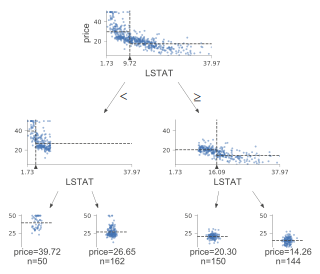

In [22]:
t = DecisionTreeRegressor(max_features=1, max_depth=2, random_state=999)#, min_samples_leaf=80)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

In [25]:
df_boston = df_boston.sample(len(df_boston), replace=True)
# X, y = df_boston.drop('y', axis=1), df['y']
X, y = df_boston[['LSTAT']], df_boston['y']

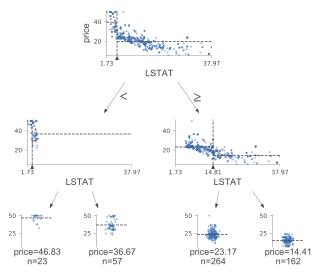

In [26]:
t = DecisionTreeRegressor(max_features=1, max_depth=2, random_state=999)#, min_samples_leaf=80)
# t = DecisionTreeRegressor(max_features=1.0, min_samples_leaf=80)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

## Error vs num trees

In [3]:
def sim_ntrees(X_train, X_test, y_train, y_test,
                max_features = 'auto',
                min_samples_leaf=1,      # lowest bias but increases variance
                ntrials = 5,
              tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50]):

    all_test_scores = np.zeros(shape=(ntrials,len(tree_sizes)))
    for i in range(ntrials):
        print(f" {i}", end='')
        test_scores = []
        for j,n_estimators in enumerate(tree_sizes):
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=True,
                                      n_jobs=-1)
            rf.fit(X_train, y_train)
            s = mean_absolute_error(y_test, rf.predict(X_test))
    #         s = rf.score(X_test, y_test)
            test_scores.append(s)

        all_test_scores[i] = test_scores
        avg = np.mean(test_scores)
        
    return all_test_scores, tree_sizes

### Fixed train/test, effect of num trees

In [4]:
df_rent = pd.read_csv("data/rent-ideal.csv")
X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
y = df_rent['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

#max_features = X_train.shape[1]
max_features = 1
# max_features = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, max_features=max_features)
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1 2 3 4

array([3.83398722, 3.15218337, 3.1119464 , 1.96648118, 1.24723706,
       2.30109198, 1.40066136, 0.65593046, 0.93264807, 1.04797978,
       0.4227188 , 0.33009388])

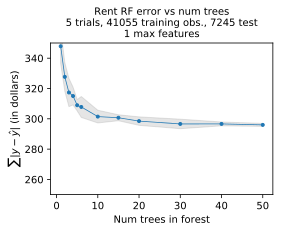

In [5]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

# ax2 = ax.twinx()
# b = ax2.plot(tree_sizes, test_variances*3, lw=1, label="test set MAE $3\sigma$", c='orange')
# ax2.yaxis.label.set_color('orange')
# #ax2.set_ylabel("Test $\sigma$")
# ax2.tick_params(axis='y', colors='orange')
# ax2.set_ylim(-0.002,15.0)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$ (in dollars)")
ax.set_ylim(250,350)
# lines = a+b
# labels = [l.get_label() for l in lines]
# ax.legend(lines,labels,loc='upper right')

#ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==X_train.shape[1]:
    ax.set_title(f"Rent bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features", fontsize=10)
else:
    ax.set_title(f"Rent RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features", fontsize=10)

#### Pick num trees

In [6]:
df_rent = pd.read_csv("data/rent-ideal.csv")
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=20,
                               min_samples_leaf=1,
                               max_features=X.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8637258827763737, 291.4526299964266)

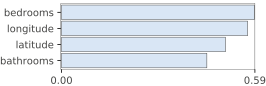

In [7]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### Select max features

In [8]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=20,
                               min_samples_leaf=1,
                               max_features=X.shape[1]-3,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8656725236777696, 292.31113761953964)

Can crank num trees up if you want

In [9]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=100,
                               min_samples_leaf=1,
                               max_features=X.shape[1]-3,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8688095898212487, 288.51967211195836)

## Bulldozer

In [10]:
def bulldozer(basefeatures = ['SalesID',
                    'MachineID', 'ModelID',
                    'datasource', 'YearMade',
                    # some missing values but use anyway:
                    'auctioneerID', 'MachineHoursCurrentMeter']):
    df_bull = pd.read_feather("data/bulldozer-train.feather") # these are sorted by date

    df_bull = df_bull.fillna(0) # flip missing numeric values to zeros

    ntest = 15_000
    df_bull_test = df_bull.iloc[-ntest:] # take only last 100,000 records
    df_bull_train = df_bull.iloc[-(100_000+ntest):-ntest] # train only last 100,000 records

    X_train, y_train = df_bull_train[basefeatures], df_bull_train['SalePrice']
    X_test, y_test = df_bull_test[basefeatures], df_bull_test['SalePrice']

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = bulldozer()

#max_features = len(X_train.columns)
max_features = len(X_train.columns)-1
min_samples_leaf = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, ntrials=ntrials,
                                         max_features=max_features,
                                         min_samples_leaf=min_samples_leaf,
                                        tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50,100])
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1 2 3 4

array([320.03707292, 103.48564567, 232.45665367,  51.55118121,
       110.38101291, 161.59166185,  84.69972787,  77.25399632,
        24.57978752,  61.05345207,  33.08067421,  23.41569154,
        31.09620384])

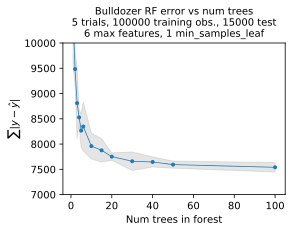

In [12]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$")
ax.set_ylim(7000,10_000)
#ax.legend(loc='upper right')

#ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==len(X_train.columns):
    ax.set_title(f"Bulldozer bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)
else:
    ax.set_title(f"Bulldozer RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)

#### Tuning; find num trees first

In [13]:
X_train, X_test, y_train, y_test = bulldozer()

scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=30,
                               min_samples_leaf=1,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.7599286229952524, 7557.478486222222)

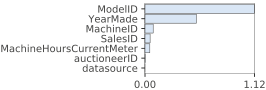

In [14]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### Set min_samples_leaf

(max_features is best at p).

Slight improvement with `min_samples_leaf`=2

In [15]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=30,
                               min_samples_leaf=2,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.758532523580415, 7539.83190924207)

Now crank num trees

In [16]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=150,
                               min_samples_leaf=2,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.7637785049890813, 7459.6136824173755)